In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
confirmed_df = pd.read_csv(r"C:\Users\micha\OneDrive\Desktop\Final Proj\Data\covid19_confirmed.csv")
deaths_df = pd.read_csv(r"C:\Users\micha\OneDrive\Desktop\Final Proj\Data\covid19_deaths.csv")
recoveries_df = pd.read_csv(r"C:\Users\micha\OneDrive\Desktop\Final Proj\Data\covid19_recovered.csv")
latest_data = pd.read_csv(r"C:\Users\micha\OneDrive\Desktop\Final Proj\Data\July29_daily.csv")
us_medical_data = pd.read_csv(r"C:\Users\micha\OneDrive\Desktop\Final Proj\Data\July29_US.csv")

In [5]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001.0,Abbeville,South Carolina,US,7/30/2020 4:35,34.223334,-82.461707,279,6,0,273.0,"Abbeville, South Carolina, US",1137.521915,2.150538
1,22001.0,Acadia,Louisiana,US,7/30/2020 4:35,30.295065,-92.414197,2266,70,0,2196.0,"Acadia, Louisiana, US",3652.187928,3.089144
2,51001.0,Accomack,Virginia,US,7/30/2020 4:35,37.767072,-75.632346,1072,15,0,1057.0,"Accomack, Virginia, US",3317.242233,1.399254
3,16001.0,Ada,Idaho,US,7/30/2020 4:35,43.452658,-116.241552,7515,53,0,7462.0,"Ada, Idaho, US",1560.465710,0.705256
4,19001.0,Adair,Iowa,US,7/30/2020 4:35,41.330756,-94.471059,20,0,0,20.0,"Adair, Iowa, US",279.642058,0.000000


In [4]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,7/20/2020,7/21/2020,7/22/2020,7/23/2020,7/24/2020,7/25/2020,7/26/2020,7/27/2020,7/28/2020,7/29/2020
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,35526,35615,35727,35928,35981,36036,36157,36263,36368,36471
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,4171,4290,4358,4466,4570,4637,4763,4880,4997,5105
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,23691,24278,24872,25484,26159,26764,27357,27973,28615,29229
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,884,884,889,889,897,897,897,907,907,918
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,749,779,812,851,880,916,932,950,1000,1078


In [6]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,7/30/2020 4:35,32.3182,-86.9023,83782,1538,32510.0,49734,1,1708.726063,668275.0,9893.0,1.835717,84000001,USA,13629.406190,11.808026
1,Alaska,US,7/30/2020 4:35,61.3707,-152.4044,2798,22,854.0,1922,2,382.478180,223664.0,NaN,0.786276,84000002,USA,30574.195710,NaN
2,American Samoa,US,7/30/2020 4:35,-14.2710,-170.1320,0,0,NaN,0,60,0.000000,1037.0,NaN,NaN,16,ASM,1863.733578,NaN
3,Arizona,US,7/30/2020 4:35,33.7298,-111.4312,168273,3454,21994.0,142825,4,2311.849739,901429.0,10060.0,2.052617,84000004,USA,12384.449070,5.978380
4,Arkansas,US,7/30/2020 4:35,34.9697,-92.3731,40968,434,33938.0,6596,5,1357.543432,495605.0,2747.0,1.059363,84000005,USA,16422.703400,6.705233


In [7]:
cols = confirmed_df.keys()

In [8]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [9]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

us_cases = [] 
us_deaths = [] 
us_recoveries = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    
    #case studies
us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
                
                #average case studies
us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())

        #recoveries
us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())

Getting daily increases and moving averages

In [10]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 14

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)
us_daily_increase = daily_increase(us_cases)

world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)
us_daily_death = daily_increase(us_deaths)

world_daily_recovery = daily_increase(total_recovered)
world_recovery_avg = moving_average(total_recovered, window)
world_daily_recovery_avg = moving_average(world_daily_recovery, window)
us_daily_recovery = daily_increase(us_recoveries)

#Average

world_active_avg = moving_average(total_active, window)

In [11]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [12]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [14]:
start = '7/29/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [15]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], world_cases[50:], test_size=0.12, shuffle=False) 

In [ ]:
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
degree = [3, 4, 5]

svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

svm = SVR(kernel='poly')
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

In [ ]:
svm_search.best_params_

In [16]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 121631.57727993904
MSE: 18905298239.9357


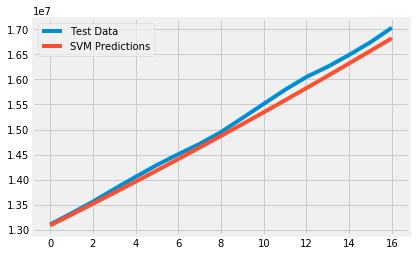

In [17]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [18]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)http://http://localhost:8888/notebooks/Final_Project%20.ipynb
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

SyntaxError: invalid syntax (<ipython-input-18-1cd4e789baa9>, line 2)

In [19]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

NameError: name 'poly_X_train_confirmed' is not defined

In [20]:
print(linear_model.coef_)

AttributeError: 'LinearRegression' object has no attribute 'coef_'

NameError: name 'test_linear_pred' is not defined

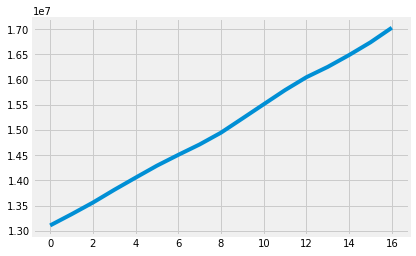

In [21]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

In [22]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

NameError: name 'bayesian_search' is not defined

NameError: name 'test_bayesian_pred' is not defined

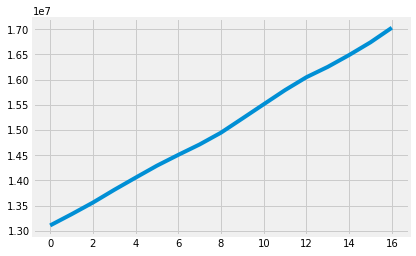

In [23]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

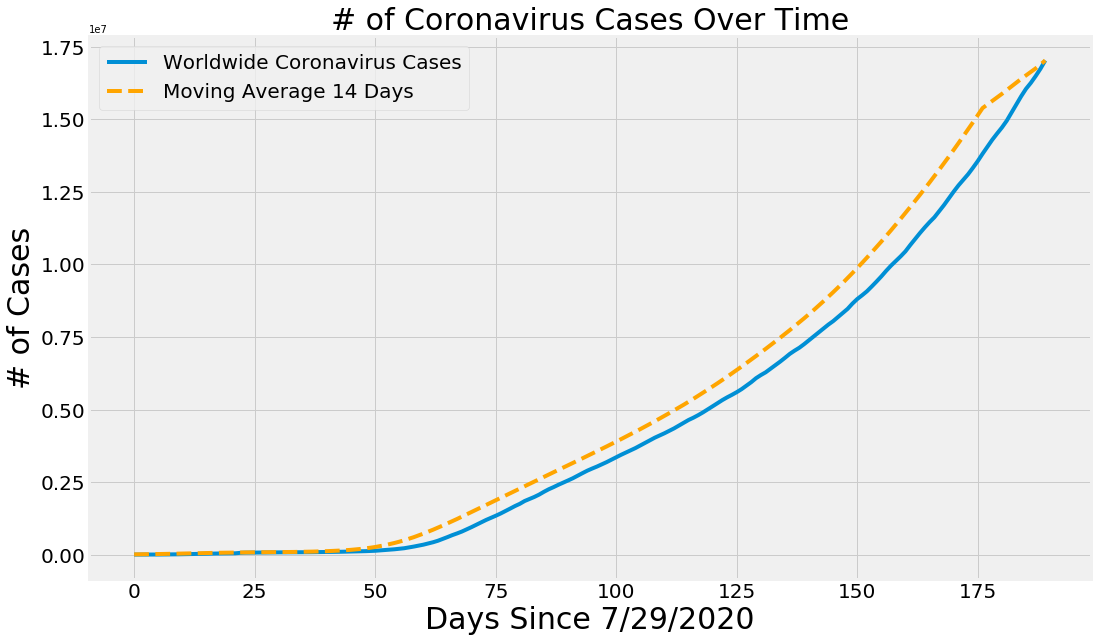

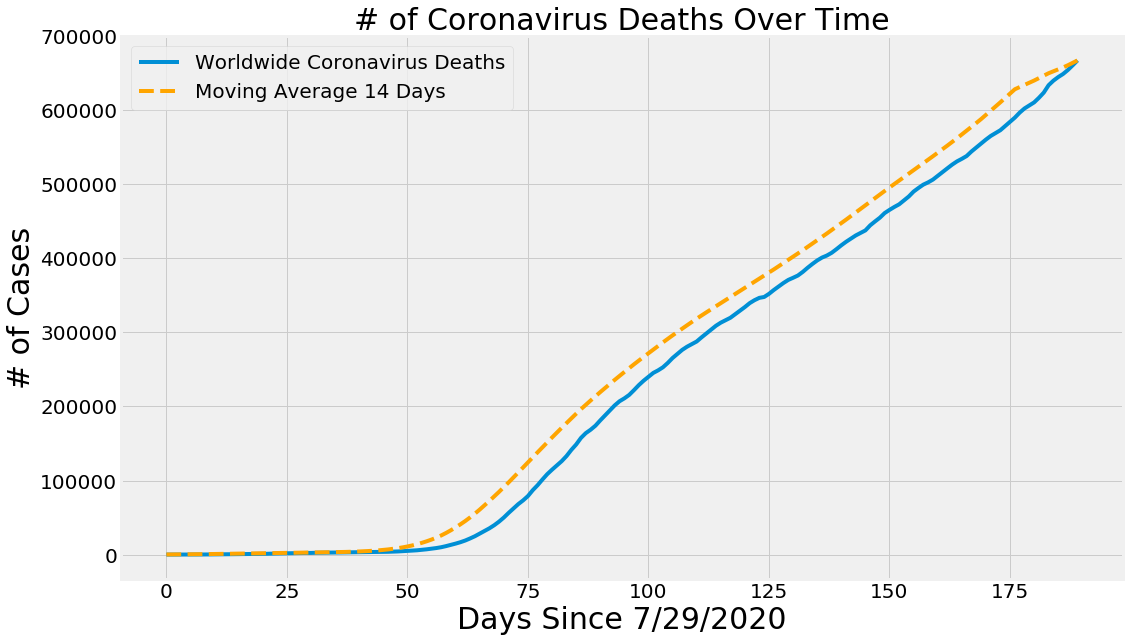

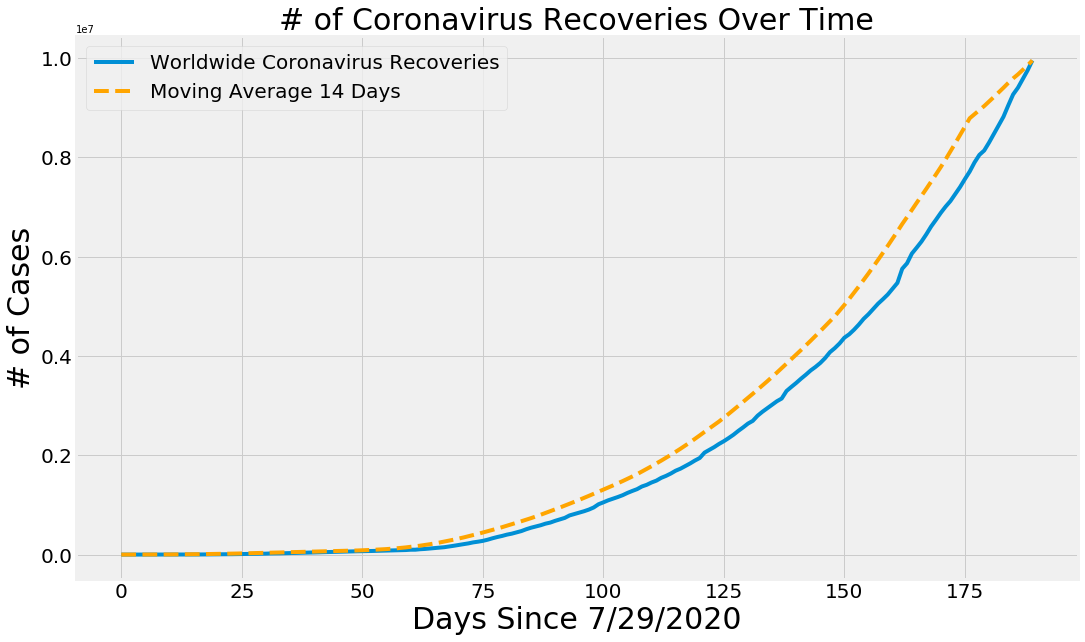

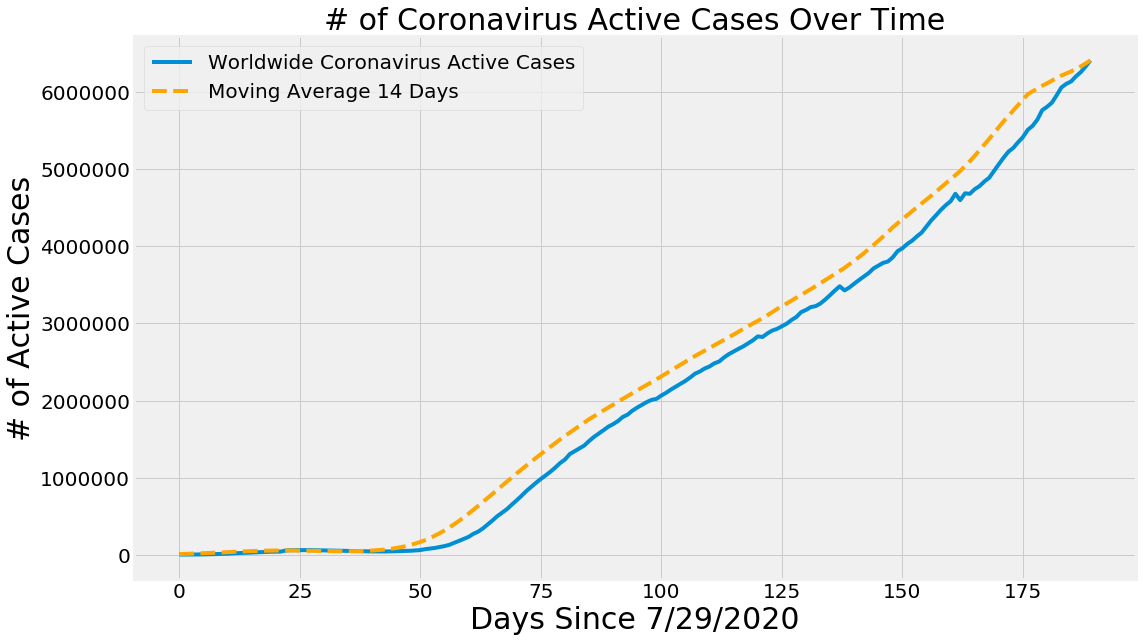

In [24]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 7/29/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average 14 Days'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths)
plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 7/29/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average 14 Days'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_recovered)
plt.plot(adjusted_dates, world_recovery_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 7/29/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Recoveries', 'Moving Average 14 Days'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_active)
plt.plot(adjusted_dates, world_active_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 7/29/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.legend(['Worldwide Coronavirus Active Cases', 'Moving Average 14 Days'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

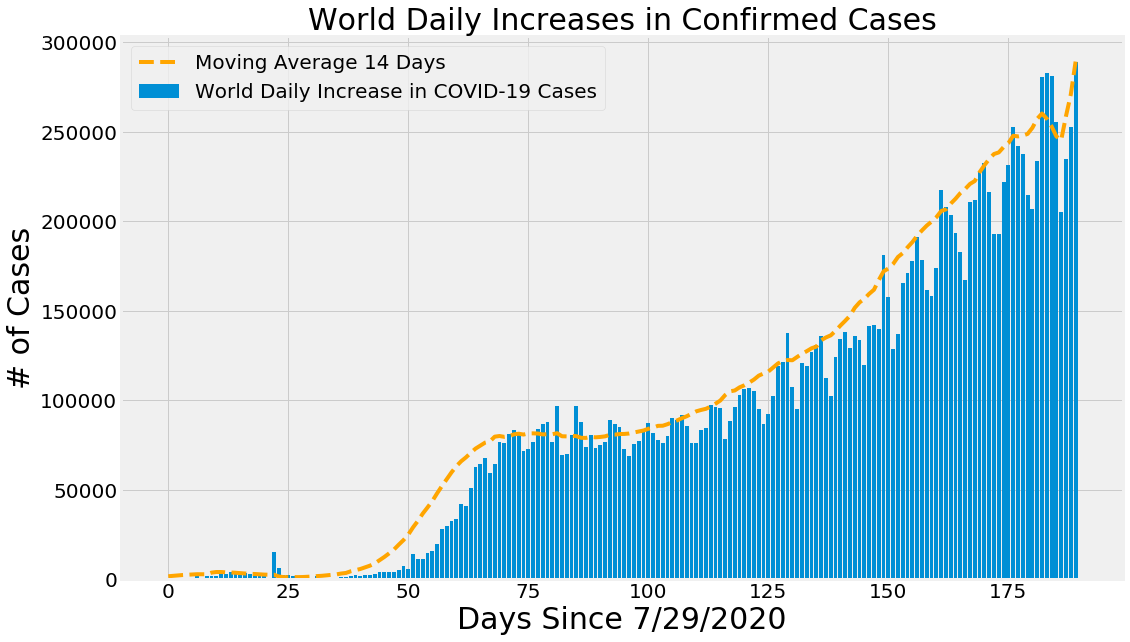

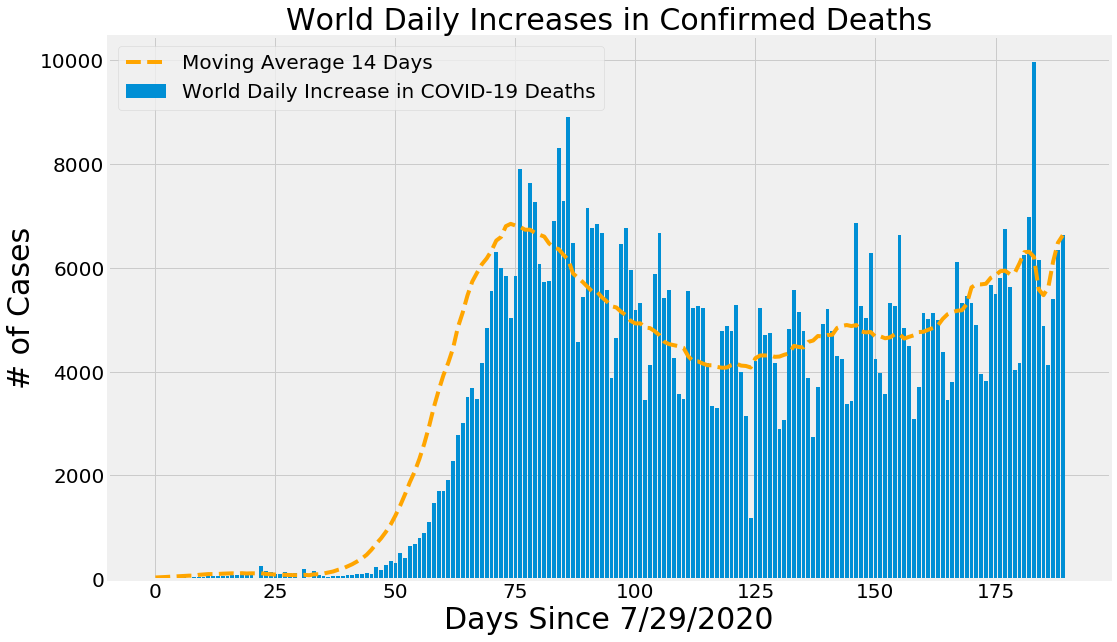

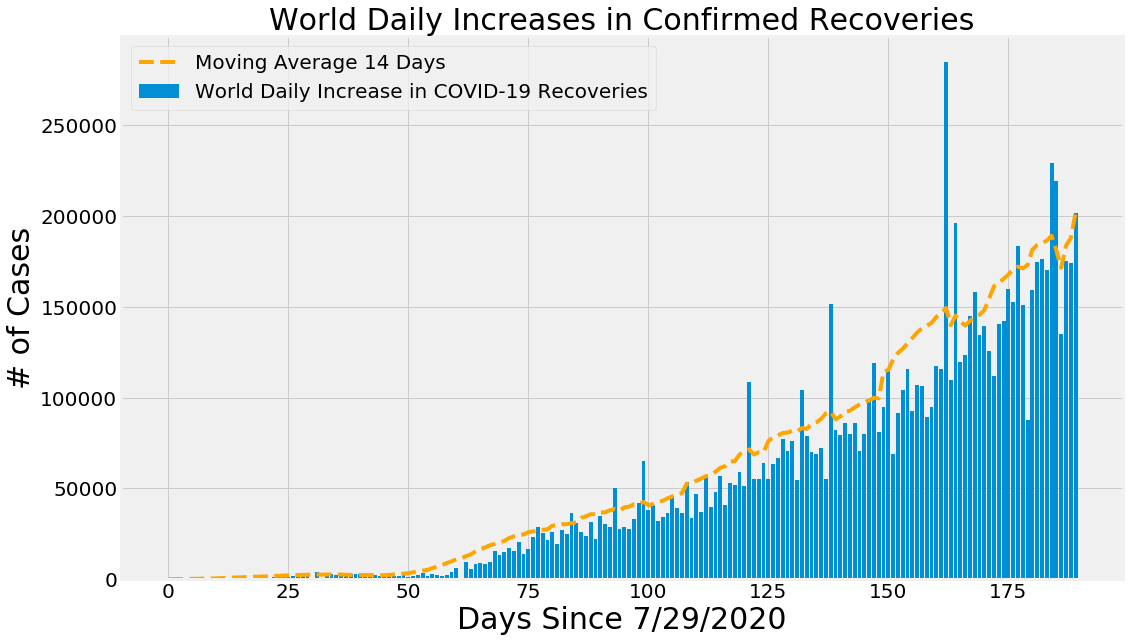

In [25]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 7/29/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average 14 Days', 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_death)
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 7/29/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average 14 Days', 'World Daily Increase in COVID-19 Deaths'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_recovery)
plt.plot(adjusted_dates, world_daily_recovery_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 7/29/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average 14 Days', 'World Daily Increase in COVID-19 Recoveries'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [26]:
def country_plot(x, y1, y2, y3, y4, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)
    recovery_increase_avg = moving_average(y4, window)
    
    plt.figure(figsize=(16, 10))
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average 14 Days'], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 7/29/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average 14 Days', '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 7/29/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average 14 Days', '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 7/29/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y4)
    plt.plot(x, recovery_increase_avg, color='red', linestyle='dashed')
    plt.legend([ 'Moving Average 14 Days', '{} Daily Increase in Confirmed Recoveries'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 7/29/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()